# imports & setup

In [1]:
import importlib
import logging
import os
from pprint import pprint

import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import scipy.stats
from cloudpathlib import AnyPath as Path

import helpers
from helpers.pseudobulk_evaluation import deg_analysis

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(process)d/%(threadName)s %(name)s %(levelname)s\n%(message)s"
)
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

In [4]:
logging.getLogger("gcsfs").setLevel("INFO")
logging.getLogger("google.cloud.bigquery").setLevel("DEBUG")
logging.getLogger("helpers").setLevel("DEBUG")
logging.getLogger("helpers.pseudobulk_evaluation.deg_analysis").setLevel("INFO")
logging.getLogger("pandas").setLevel("DEBUG")
logging.getLogger("pyarrow").setLevel("DEBUG")

In [5]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")
logger.debug("test debug-level message")

2022-07-17 22:30:27,536 8370/MainThread __main__ DEBUG
test debug-level message


# load bulk RNA-seq TPM data

## TCGA SKCM (real)

In [6]:
uri_tcga_skcm_bulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures_real_tcga_skcm/tpm.parquet"
)

In [7]:
ddf_tcga_skcm_bulk_rnaseq = dd.read_parquet(uri_tcga_skcm_bulk_rnaseq, engine="pyarrow")
logger.debug(ddf_tcga_skcm_bulk_rnaseq.dtypes)

2022-07-17 22:30:32,841 8370/MainThread google.auth._default WARNING
No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
2022-07-17 22:30:32,843 8370/MainThread gcsfs.credentials DEBUG
Connected with method google_default
2022-07-17 22:30:32,845 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 22:30:32,845 8370/fsspecIO gcsfs.credentials DEBUG
GCS refresh
2022-07-17 22:30:33,252 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 22:30:33,401 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 22:30:33,542 8370/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data

In [8]:
ddf_tcga_skcm_bulk_rnaseq

,gene_symbol,aliquot_barcode,tpm
npartitions=1,,,
,category[unknown],category[unknown],float64
,...,...,...


## pseudobulks

In [9]:
uri_pseudobulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet"
)

In [10]:
ddf_pseudobulk_rnaseq = (
    dd.read_parquet(
        uri_pseudobulk_rnaseq,
        engine="pyarrow",
    )
    .replace({"malignant_from_one_sample": {"True": True, "False": False}})
    .astype({"n_cells": "uint8", "malignant_from_one_sample": "bool"})
    .rename(columns={"tcga_aliquot_barcode_for_fractions": "aliquot_barcode"})
)

logger.debug(ddf_pseudobulk_rnaseq.dtypes)

2022-07-17 22:30:34,254 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-17 22:30:34,400 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-17 22:30:34,539 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-17 22:30:34,691 8370/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures%2Fn_cells=5%2Fmalignant_from_one_sample=True%2Fdata.parquet?alt=media, (), {'Range': 'bytes=41829238-41894773'}
2022-07-17 22:30:34,878 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_

In [11]:
ddf_pseudobulk_rnaseq

,gene_symbol,aliquot_barcode,tpm,n_cells,malignant_from_one_sample
npartitions=1,,,,,
,category[unknown],category[unknown],float64,uint8,bool
,...,...,...,...,...


# analysis

In [18]:
logging.getLogger("helpers.pseudobulk_evaluation.deg_analysis").setLevel(
    "INFO"
)  # DEBUG is loud

In [19]:
df_sample_metadata = deg_analysis.get_tcga_skcm_metastatic_sample_metadata()

2022-07-17 22:34:29,985 8370/MainThread helpers.datasets DEBUG
loading TCGA SKCM fractions estimated by CIBERSORTx
2022-07-17 22:34:29,988 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'downloaded_manually/derek_csx_tcga_skcm/CIBERSORTx_Job8_Results.txt'), None
2022-07-17 22:34:30,415 8370/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/downloaded_manually%2Fderek_csx_tcga_skcm%2FCIBERSORTx_Job8_Results.txt?alt=media, (), {'Range': 'bytes=0-86860'}
Downloading:   0%|                                         | 0/369 [00:00<?, ?rows/s]2022-07-17 22:34:33,981 8370/MainThread google.cloud.bigquery._pandas_helpers DEBUG
Started reading table 'keen-dispatch-316219._f3d6852d3dddd53ba7361e949c2756f4d2d034c2.anon963500c015ce7e85114c37e4791af2a8546dee82' with BQ Storage API session 'projects/keen-dispatch-316219/locations/us/sessions/CAISDGdyT210OVdBRS1GbhoCamYaAmpk'.
Downloading: 100%|██████████████████████████████| 369/369 [00:01<00:00, 222.10rows/

In [20]:
df_gene_stats_tcga_skcm = deg_analysis.compute_all_deg_results(
    ddf_tcga_skcm_bulk_rnaseq, df_sample_metadata
)

df_gene_stats_pseudobulks = deg_analysis.compute_all_deg_results(
    ddf_pseudobulk_rnaseq, df_sample_metadata
)

2022-07-17 22:35:57,266 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 22:35:57,471 8370/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=47361643-47427178'}
2022-07-17 22:35:57,656 8370/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=4-548156'}
2022-07-17 22:35:57,916 8370/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=548293-47424233'}
2022-07-17 22:36:09,299 8370/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab

In [21]:
df_gene_stats_tcga_skcm.info(), df_gene_stats_pseudobulks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16063 entries, 0 to 16062
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   gene_symbol                      16063 non-null  category
 1   pval                             16063 non-null  float64 
 2   fold_change                      16063 non-null  float64 
 3   -log10_pval                      16063 non-null  float64 
 4   log2_fold_change                 16063 non-null  float64 
 5   -log10_pval_signed               16063 non-null  float64 
 6   pval_adj_fdr=0.05                16063 non-null  float64 
 7   -log10_pval_adj_fdr=0.05         16063 non-null  float64 
 8   -log10_pval_adj_fdr=0.05_signed  16063 non-null  float64 
 9   pval_adj_fdr=0.10                16063 non-null  float64 
 10  -log10_pval_adj_fdr=0.10         16063 non-null  float64 
 11  -log10_pval_adj_fdr=0.10_signed  16063 non-null  float64 
 12  pval

(None, None)

# plots

In [43]:
fig = px.scatter(
    df_gene_stats_tcga_skcm,
    x="-log10_pval_signed",
    y="-log10_pval_adj_fdr=0.10_signed",
    trendline="ols",
)
fig.show(renderer="browser")

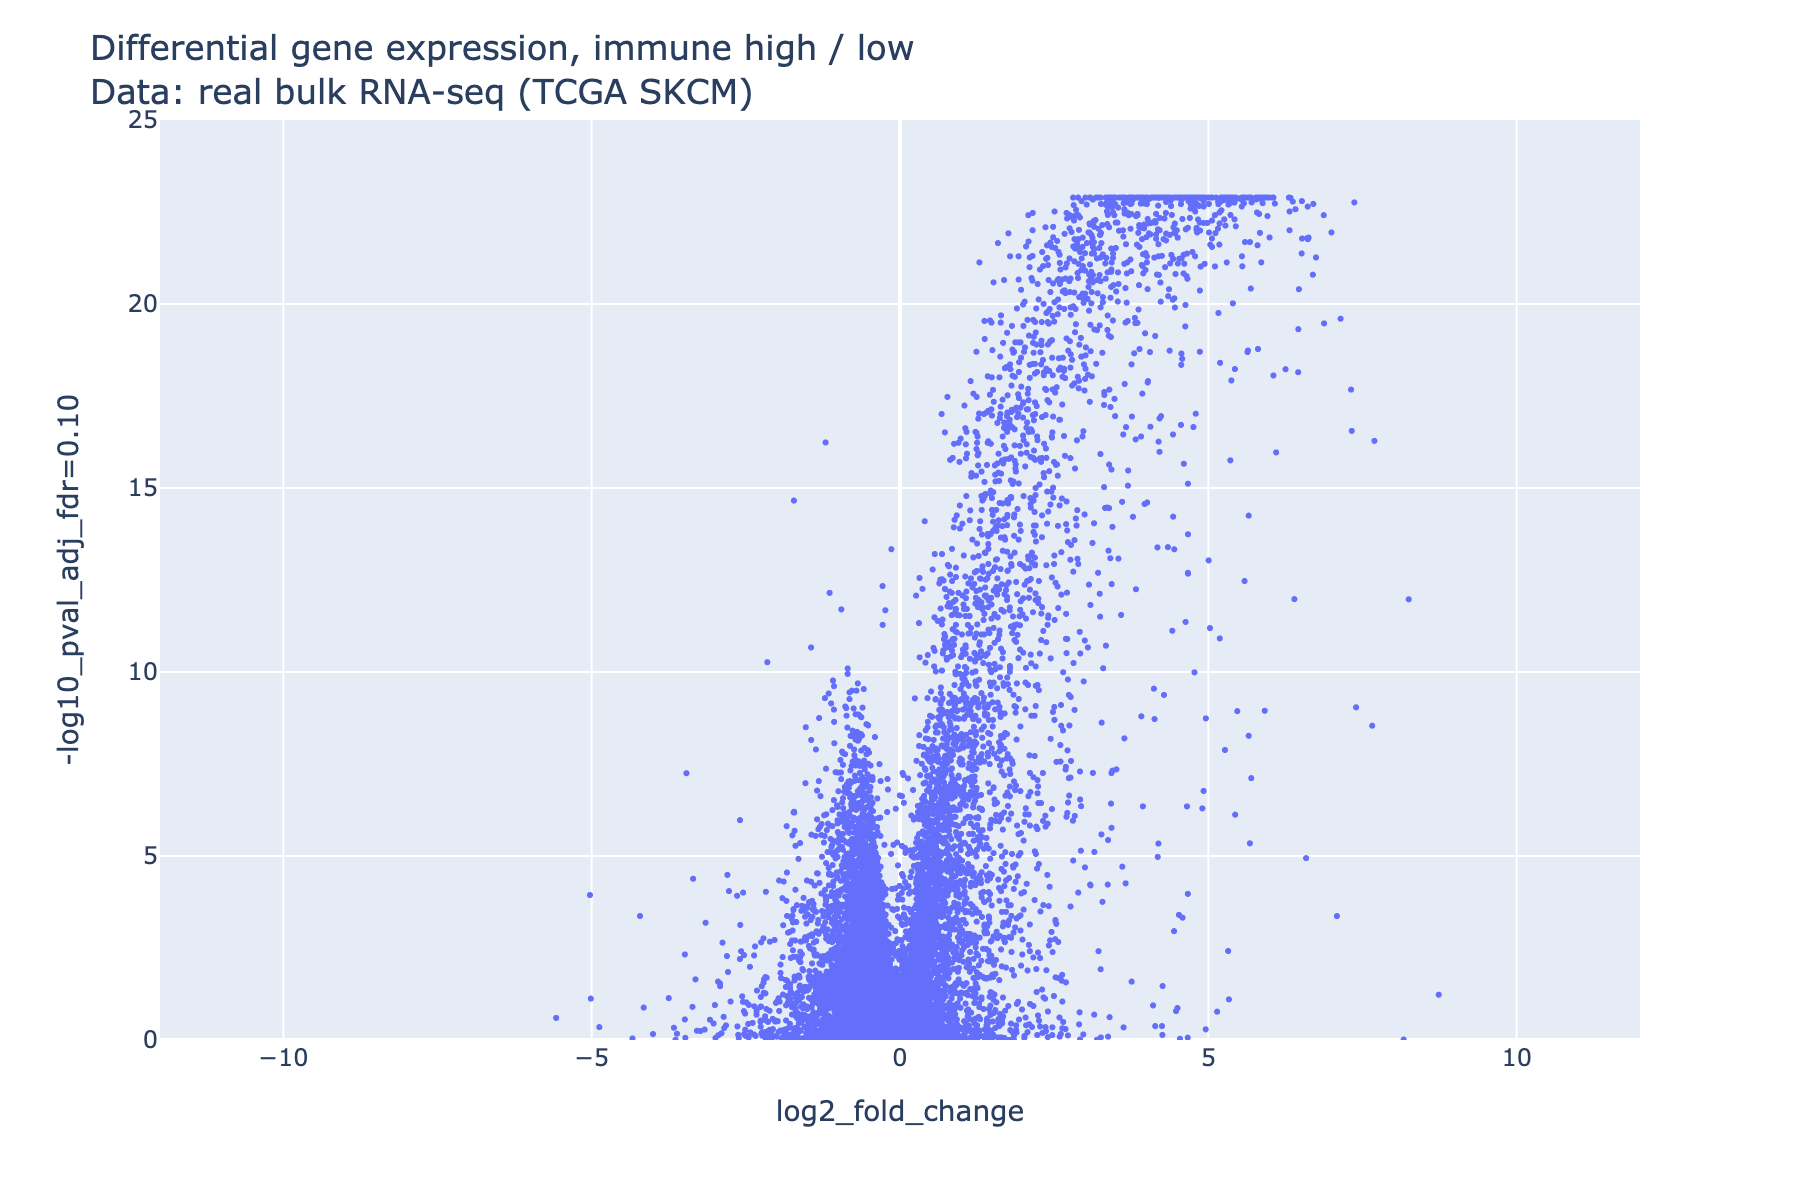

In [48]:
importlib.reload(deg_analysis)

fig = deg_analysis.make_volcano_plot(df_gene_stats_tcga_skcm)

fig.update_layout(
    title=(
        "Differential gene expression, immune high / low"
        "<br>Data: real bulk RNA-seq (TCGA SKCM)"
    ),
)

fig.show(renderer="png", scale=2, width=900, height=600)

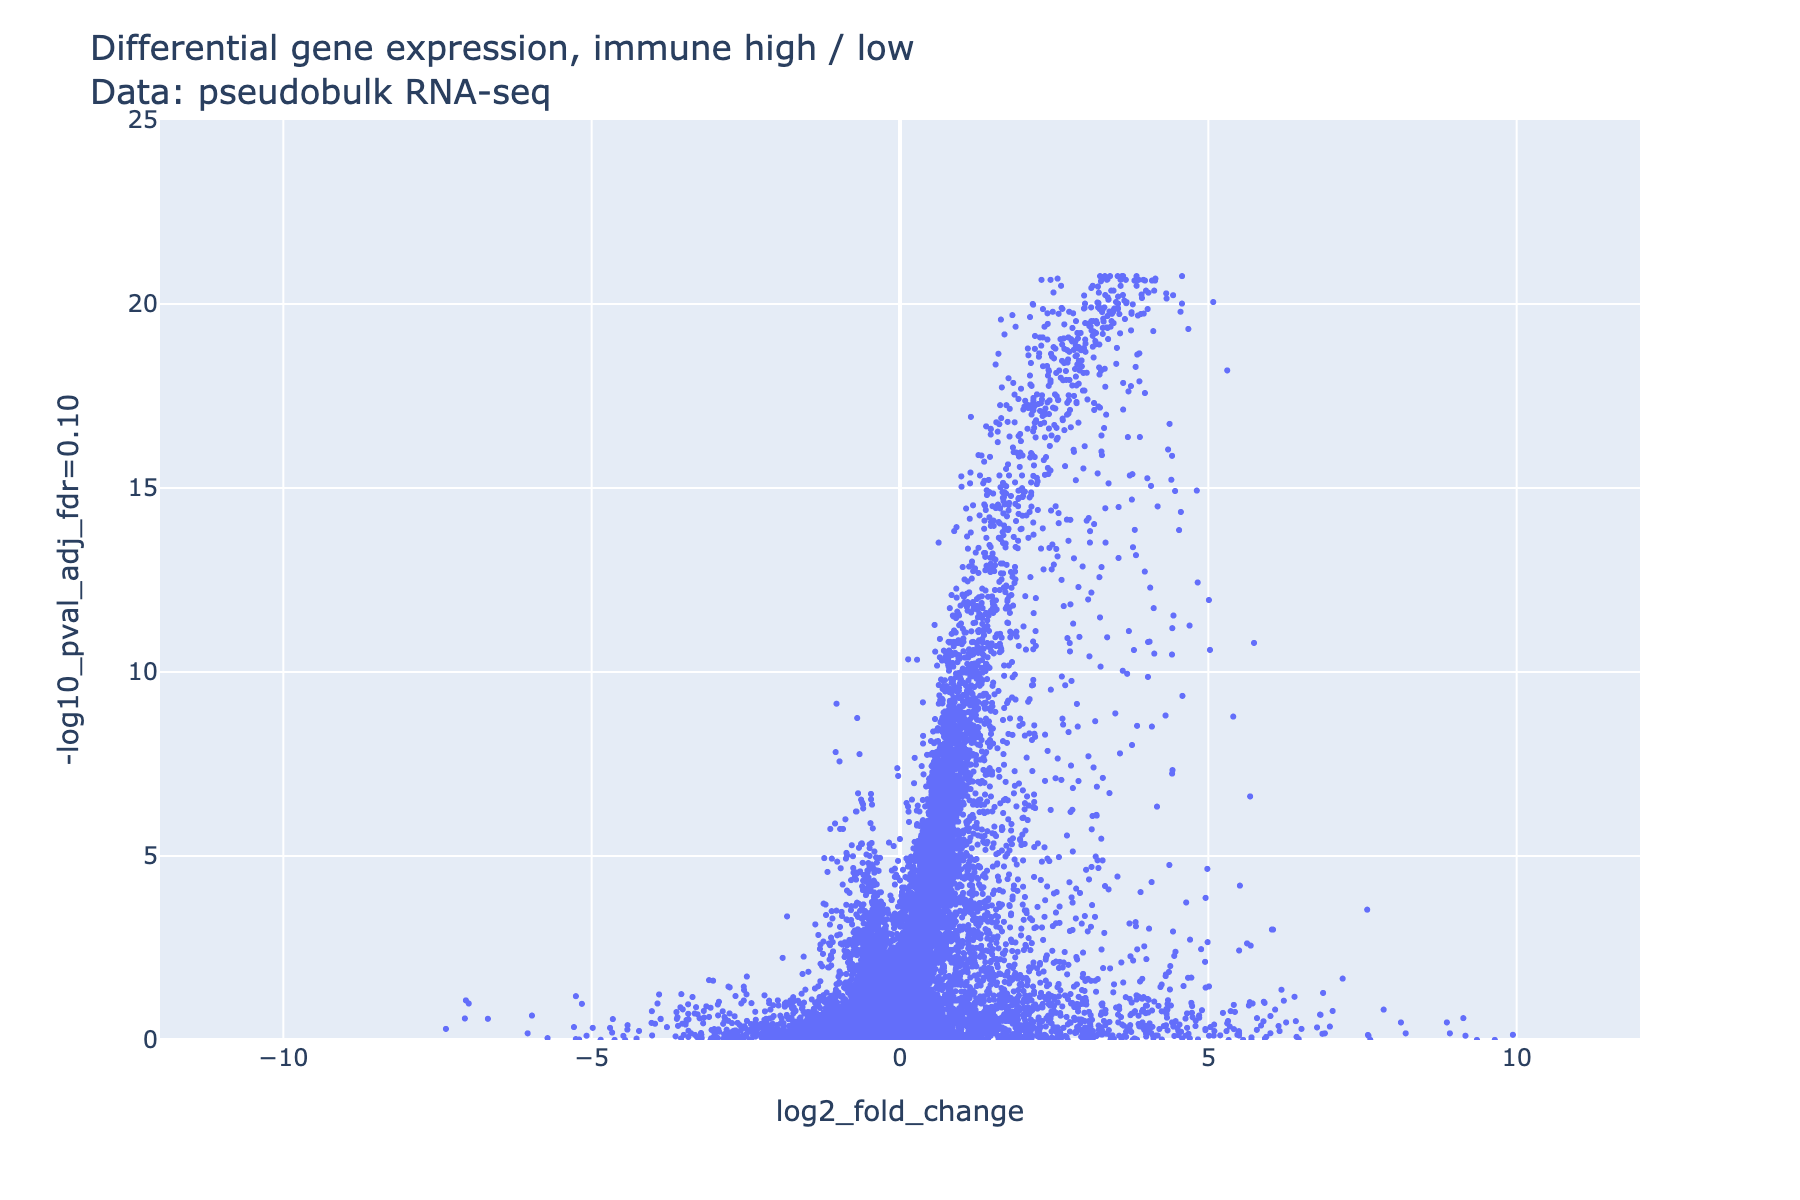

In [49]:
importlib.reload(deg_analysis)

fig = deg_analysis.make_volcano_plot(df_gene_stats_pseudobulks)

fig.update_layout(
    title=(
        "Differential gene expression, immune high / low" "<br>Data: pseudobulk RNA-seq"
    ),
)

fig.show(renderer="png", scale=2, width=900, height=600)

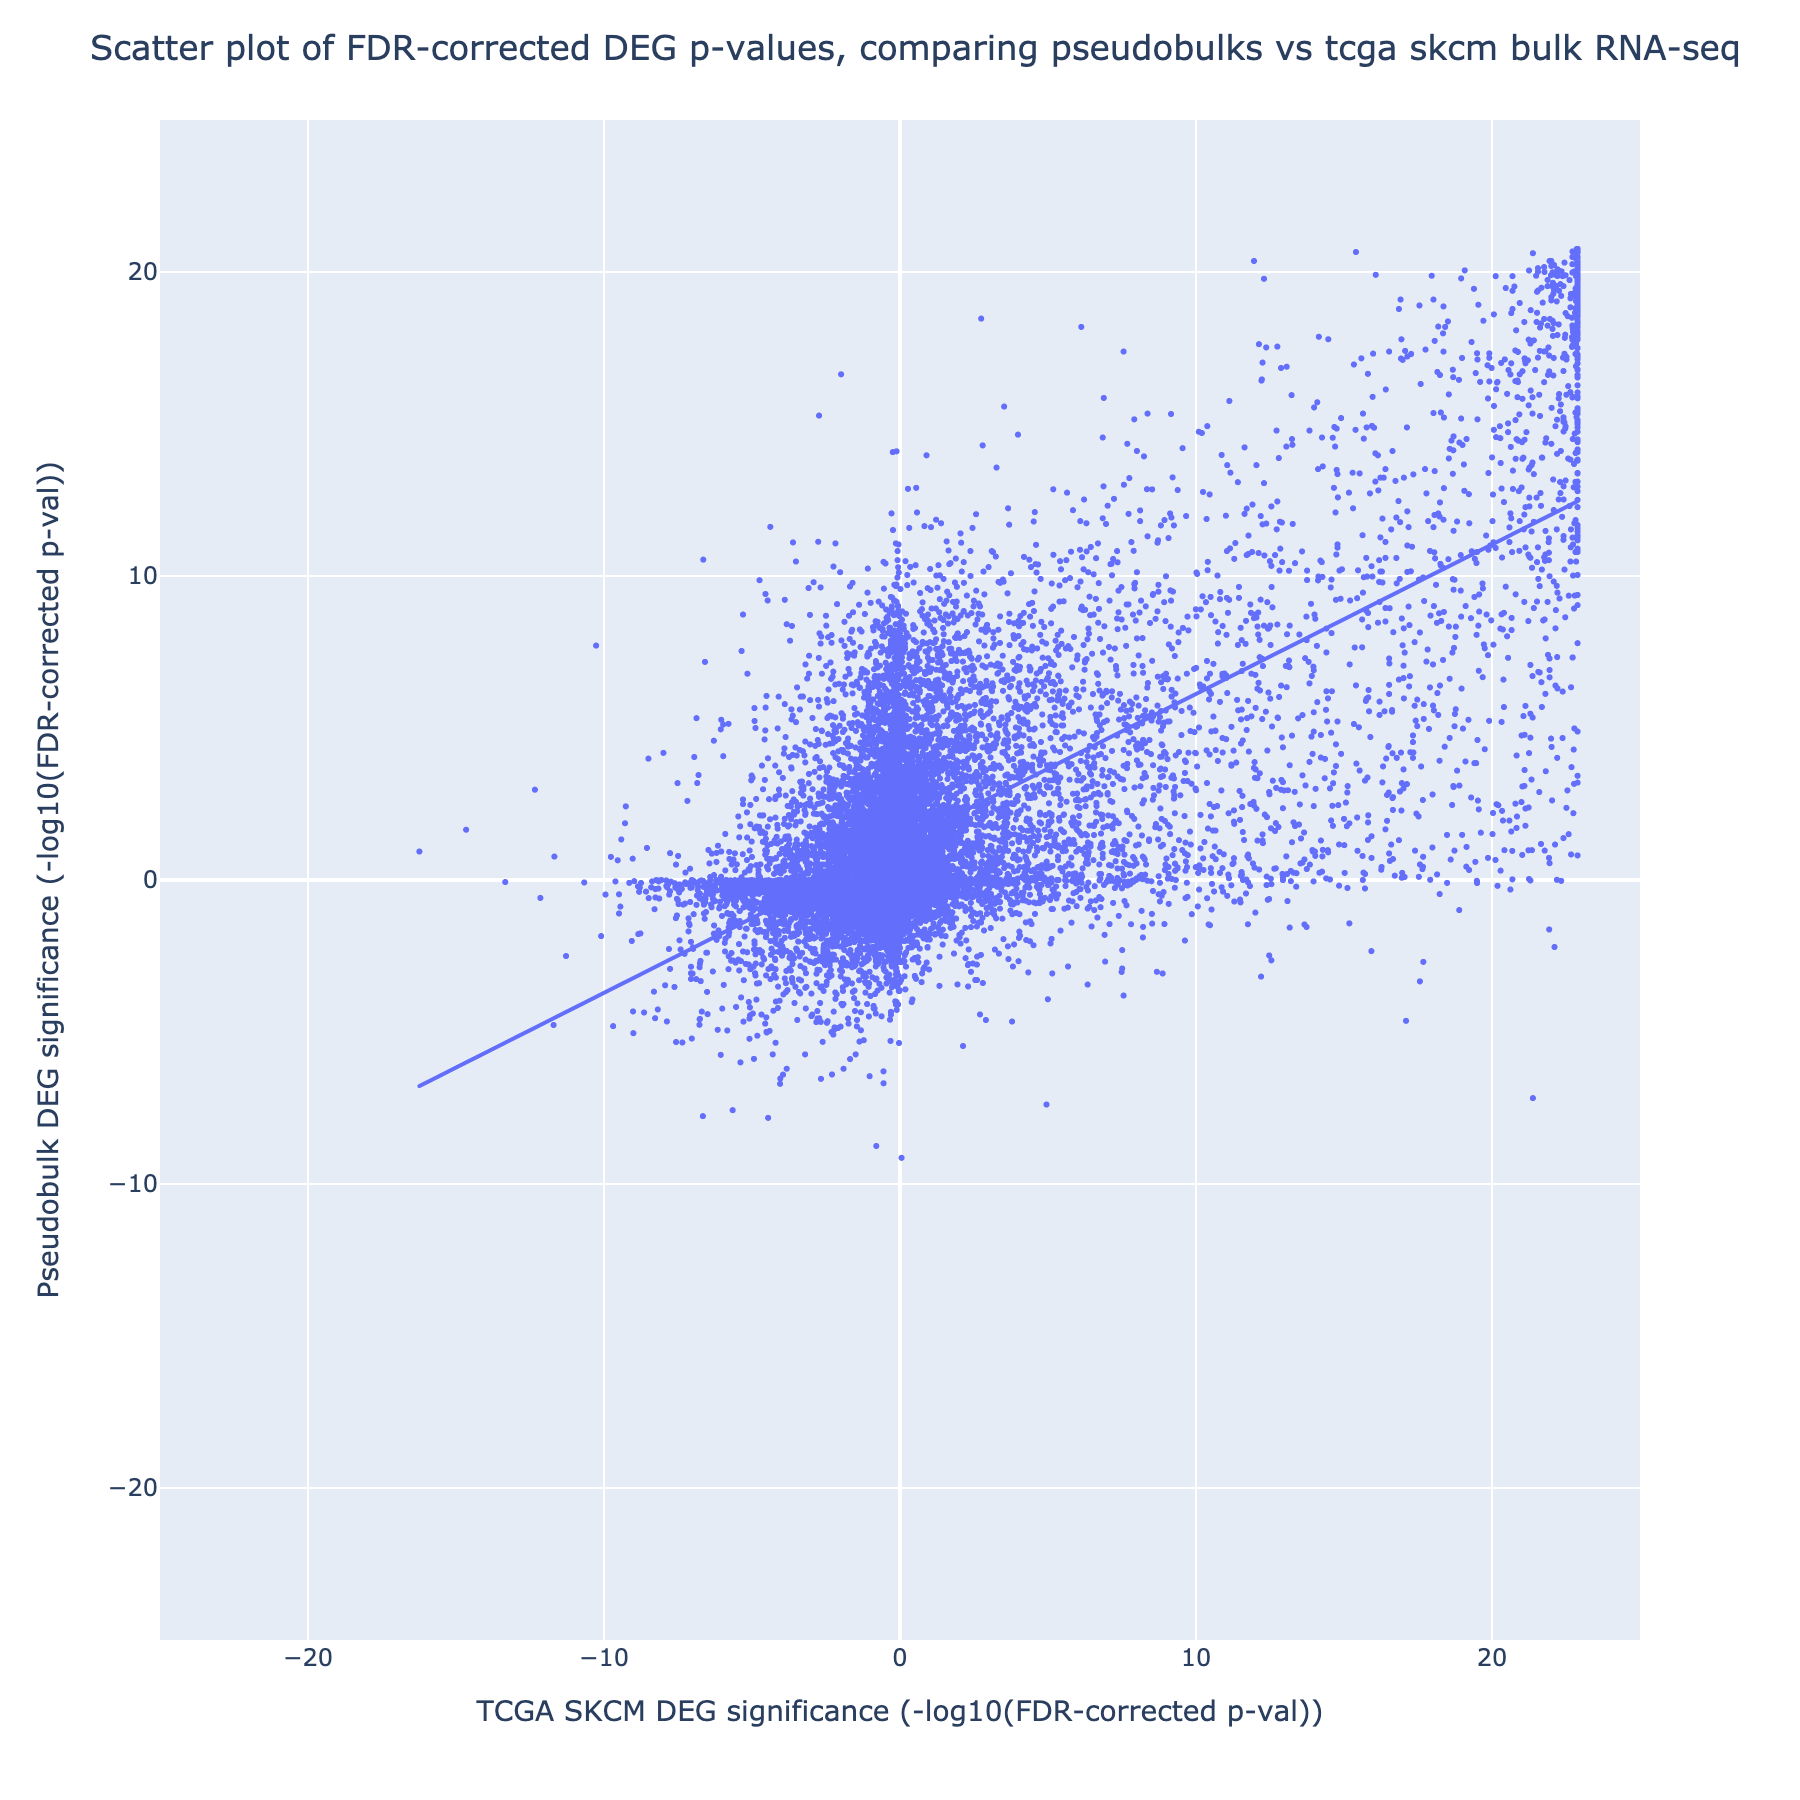

In [55]:
importlib.reload(deg_analysis)

fig = deg_analysis.make_scatter_of_signed_pvals(
    df_gene_stats_tcga_skcm, df_gene_stats_pseudobulks
)

fig.update_layout(
    title="Scatter plot of FDR-corrected DEG p-values, comparing pseudobulks vs tcga skcm bulk RNA-seq",
    xaxis_title="TCGA SKCM DEG significance (-log10(FDR-corrected p-val))",
    yaxis_title="Pseudobulk DEG significance (-log10(FDR-corrected p-val))",
)

fig.show(renderer="png", scale=2, width=900, height=900)
fig.show("browser")

Signature:
pd.crosstab(
    index,
    columns,
    values=None,
    rownames=None,
    colnames=None,
    aggfunc=None,
    margins: 'bool' = False,
    margins_name: 'str' = 'All',
    dropna: 'bool' = True,
    normalize=False,
) -> 'DataFrame'
Docstring:
Compute a simple cross tabulation of two (or more) factors. By default
computes a frequency table of the factors unless an array of values and an
aggregation function are passed.

Parameters
----------
index : array-like, Series, or list of arrays/Series
    Values to group by in the rows.
columns : array-like, Series, or list of arrays/Series
    Values to group by in the columns.
values : array-like, optional
    Array of values to aggregate according to the factors.
    Requires `aggfunc` be specified.
rownames : sequence, default None
    If passed, must match number of row arrays passed.
colnames : sequence, default None
    If passed, must match number of column arrays passed.
aggfunc : function, optional
    If specified, re

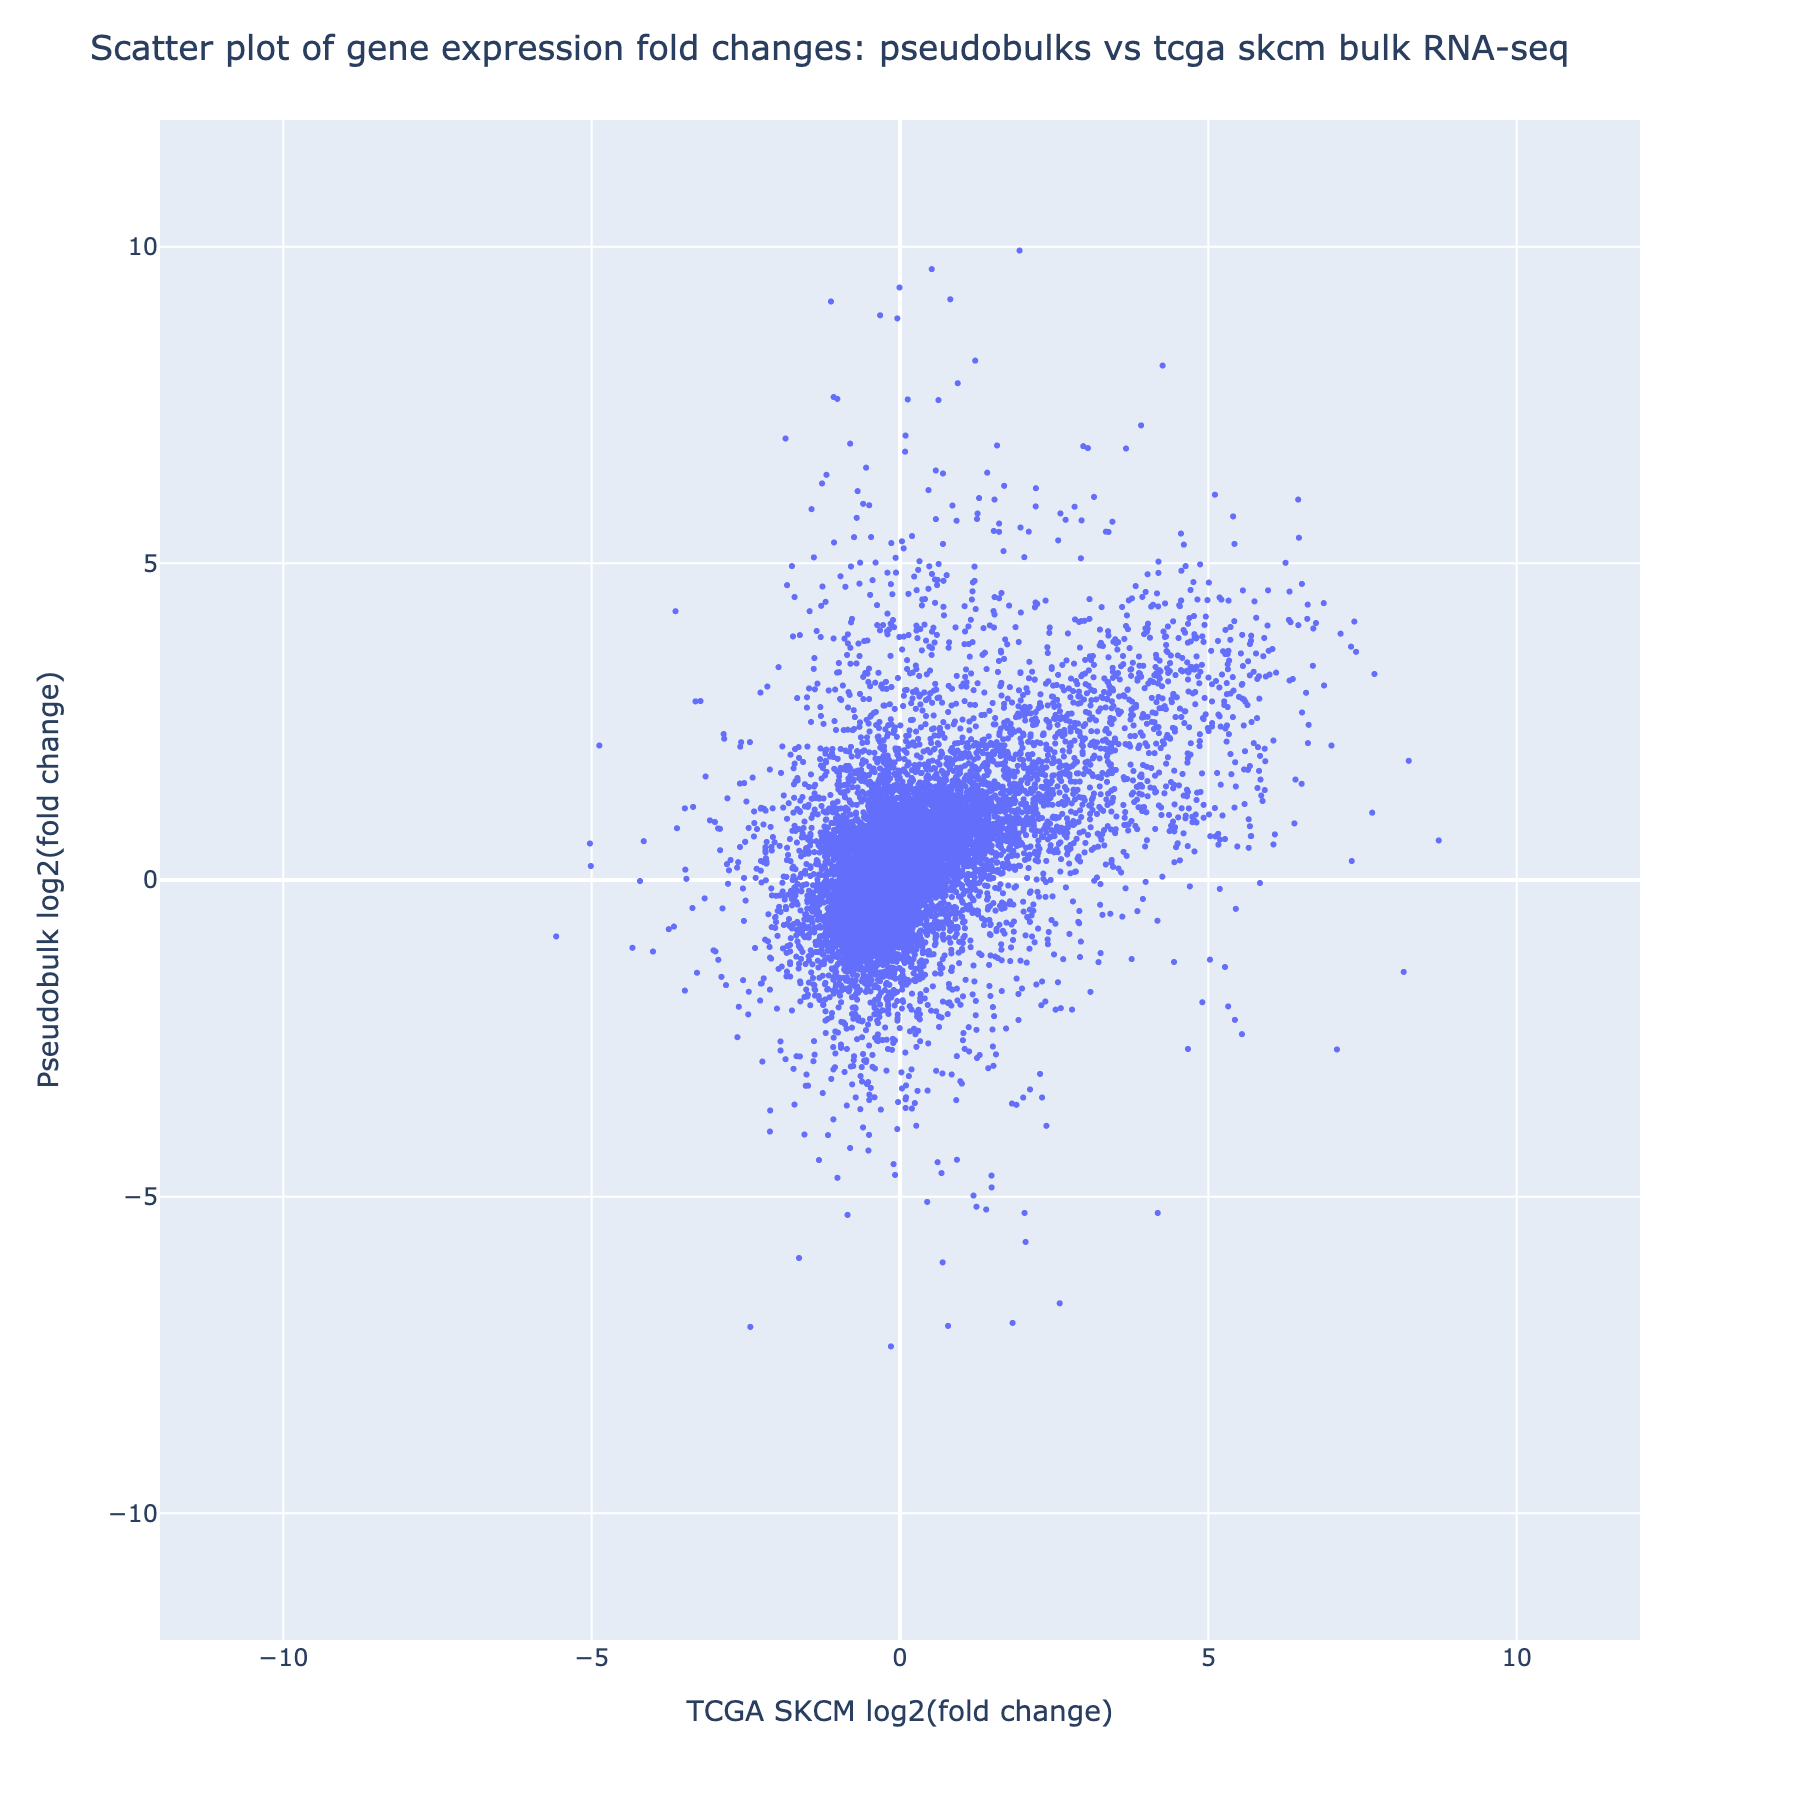

In [66]:
importlib.reload(deg_analysis)

fig = deg_analysis.make_scatter_of_log2_fold_changes(
    df_gene_stats_tcga_skcm, df_gene_stats_pseudobulks
)

fig.update_layout(
    title="Scatter plot of gene expression fold changes: pseudobulks vs tcga skcm bulk RNA-seq",
    xaxis_title="TCGA SKCM log2(fold change)",
    yaxis_title="Pseudobulk log2(fold change)",
)

fig.show(renderer="png", scale=2, width=900, height=900)
# fig.show("browser")

# what's the overlap for significant genes between real, pseudo?

In [104]:
importlib.reload(deg_analysis)

TOP_FRACTION = 0.09

crosstab, odds_ratio, p_value = deg_analysis.analyze_gene_significance_overlap(
    df_gene_stats_tcga_skcm, df_gene_stats_pseudobulks, TOP_FRACTION
)
print(odds_ratio)
print(p_value, ", -log10:", -np.log10(p_value))
crosstab

36.60727845059593
0.0 , -log10: inf


significant_in_cohort_2,False,True
significant_in_cohort_1,,
False,14041,576
True,578,868
